## Preparation

In [ ]:
# Mount to your Google Drive allowing lesson files will be saved to your Drive location
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%cd 'drive/My Drive/course-v4/nbs'

/content/drive/My Drive/course-v4/nbs


In [ ]:
!pip install fastai2

     |████████████████████████████████| 184kB 4.1MB/s 


In [ ]:
!pip install fastai2>=0.0.11 graphviz ipywidgets matplotlib nbdev>=0.2.12 pandas scikit_learn azure-cognitiveservices-search-imagesearch sentencepiece

## Start from here

In [ ]:
#hide
from utils import *
from fastai2.vision.widgets import *

To download images with Bing Image Search, you should sign up at Microsoft for *Bing Image Search*. You will be given a key, which you can either paste here, replacing "XXX":

In [ ]:
key = '0c3a21d9d0a3478bba3bf23ad9fdfded'

In [ ]:
search_images_bing

<function utils.search_images_bing>

In [ ]:
results = search_images_bing(key, 'steve jobs')
ims = results.attrgot('content_url')
len(ims)

150

In [ ]:
ims[1]

'https://upload.wikimedia.org/wikipedia/commons/5/54/Steve_Jobs.jpg'

In [ ]:
person_types = 'steve jobs', 'john rambo'
path = Path('persons')

In [ ]:
if not path.exists():
    path.mkdir()
  for o in person_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o}')
        download_images(dest, urls=results.attrgot('content_url'))

In [ ]:
fns = get_image_files(path)
fns

(#298) [Path('persons/steve jobs/00000003.jpg'),Path('persons/steve jobs/00000000.jpg'),Path('persons/steve jobs/00000005.jpg'),Path('persons/steve jobs/00000008.png'),Path('persons/steve jobs/00000007.jpg'),Path('persons/steve jobs/00000002.jpg'),Path('persons/steve jobs/00000006.png'),Path('persons/steve jobs/00000001.jpg'),Path('persons/steve jobs/00000004.jpg'),Path('persons/steve jobs/00000009.jpg')...]

In [ ]:
failed = verify_images(fns)
failed

(#2) [Path('persons/steve jobs/00000002.jpg'),Path('persons/john rambo/00000060.jpg')]

In [ ]:
failed.map(Path.unlink);

### Sidebar: Getting help in jupyter notebooks

### End sidebar

## From data to DataLoaders

In [ ]:
persons = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
dls = persons.dataloaders(path)

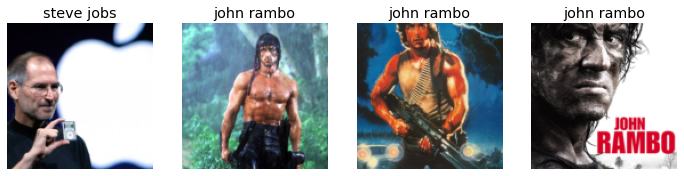

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

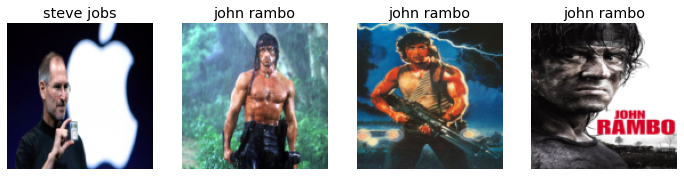

In [ ]:
persons = persons.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = persons.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

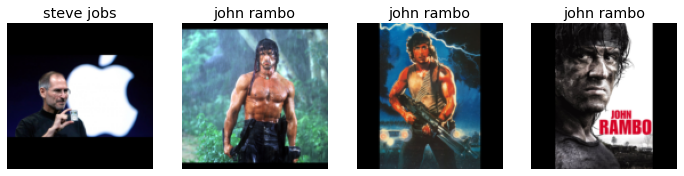

In [ ]:
persons = persons.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = persons.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

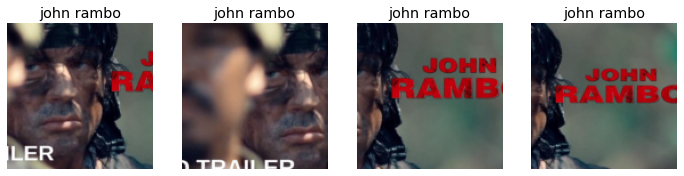

In [ ]:
persons = persons.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = persons.dataloaders(path)
dls.train.get_idxs = lambda: Inf.ones
dls.train.show_batch(max_n=4, nrows=1)

### Data augmentation

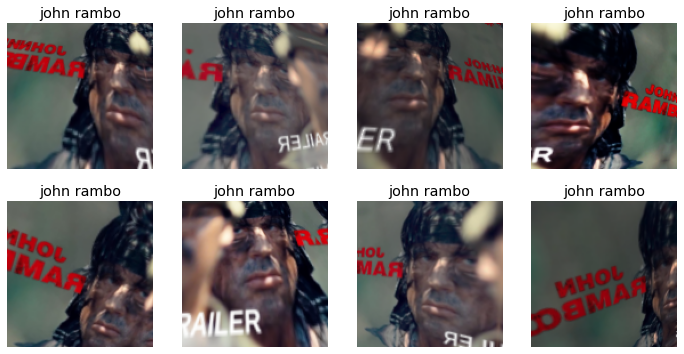

In [ ]:
persons = persons.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = persons.dataloaders(path)
dls.train.get_idxs = lambda: Inf.ones
dls.train.show_batch(max_n=8, nrows=2)

## Training your model, and using it to clean your data

In [ ]:
persons = persons.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = persons.dataloaders(path)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.148875,0.386468,0.159091,00:53


epoch,train_loss,valid_loss,error_rate,time
0,0.338250,0.140732,0.034091,01:05
1,0.233293,0.080473,0.022727,01:05
2,0.184751,0.045220,0.011364,01:04
3,0.150230,0.031357,0.011364,01:05


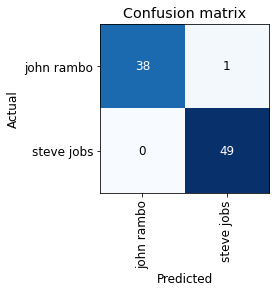

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

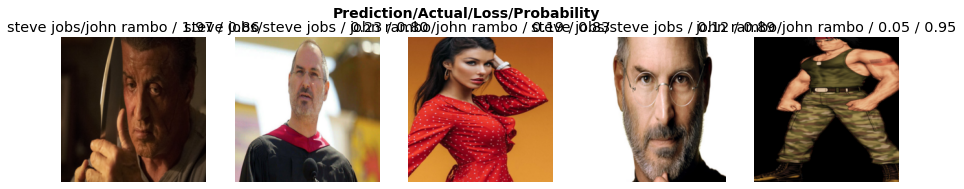

In [ ]:
interp.plot_top_losses(5, nrows=1)